In [1]:
import csv
import os
import json
import time
import random


In [2]:
with open("/home/zjusst/qms/webarena/result_stage_1_explore_v2/flitered_triplets.csv", "r") as f:
    reader = csv.reader(f)
    # 跳过第一行
    next(reader)
    triplets = [row for row in reader]
print(len(triplets))
print(triplets[0])

1028
["('812_1.json', 0, 0, 'http://reddit.com/')", "click [65] where [65] is link 'Forums'", 'The user intends to navigate to the list of available forums to explore different communities or topics.', "('812_1.json', 0, 1, 'http://reddit.com/forums')"]


In [ ]:
import networkx as nx
import numpy as np

def count_all_paths(graph_data, path_length):
    """
    使用邻接矩阵幂统计图中所有长度为path_length的路径数量。

    Args:
        graph_data (list of tuples): 你的图数据，格式为 (source_id, action, intent, target_id)。
        path_length (int): 你想要统计的路径长度 (n)。

    Returns:
        dict: 一个字典，键是路径长度，值是该长度的路径总数。
    """
    # 1. 使用NetworkX构建一个有向图，两个节点间可以有多个边
    G = nx.MultiDiGraph()
    # 先添加所有节点，以确保节点顺序是固定的
    nodes = sorted(list(set([d[0] for d in graph_data] + [d[3] for d in graph_data])))
    G.add_nodes_from(nodes)
    
    # 添加边
    edges = [(d[0], d[3]) for d in graph_data]
    G.add_edges_from(edges)
    
    # 2. 获取邻接矩阵 A
    # nodelist参数确保矩阵的行/列顺序是固定的
    A = nx.to_numpy_array(G, nodelist=nodes)
    
    
    # A_k 将存储 A 的 k 次幂
    A_k = np.copy(A) 

    # 3. 循环计算从1到n的路径
    for k in range(path_length - 1):
        A_k = A_k @ A

    # 矩阵中所有元素的和就是长度为k的路径总数
    count_k = int(np.sum(A_k))
    return count_k

# ==================== 示例用法 ====================
if __name__ == "__main__":
    # 你的图数据 (包含一个环路 A -> B -> C -> A 来展示路径爆炸)
    # graph_tuples = [
    #     ('PageA', 'action', 'intent', 'PageB'),
    #     ('PageB', 'action', 'intent', 'PageC'),
    #     ('PageC', 'action', 'intent', 'PageD'),
    #     ('PageC', 'action', 'intent', 'PageA'), # 环路
    #     ('PageD', 'action', 'intent', 'PageE'),
    #     #('PageE', 'action', 'intent', 'PageC'),
    # ]
    graph_tuples=triplets
    path_cnts = []
    # 我们来统计长度从1到5的路径
    max_n = 20
    for i in range(1, max_n + 1):
        count = count_all_paths(graph_tuples, i)
        print(f"长度为 {i} 的路径总数:\t{count}")
        path_cnts.append(count)

长度为 1 的路径总数:	1028
长度为 2 的路径总数:	6903
长度为 3 的路径总数:	55713
长度为 4 的路径总数:	515354
长度为 5 的路径总数:	4591402
长度为 6 的路径总数:	41738243
长度为 7 的路径总数:	374371684
长度为 8 的路径总数:	3365977877
长度为 9 的路径总数:	30105601303
长度为 10 的路径总数:	269057441653
长度为 11 的路径总数:	2398933898489
长度为 12 的路径总数:	21368327994130
长度为 13 的路径总数:	190113815259596
长度为 14 的路径总数:	1690312271962408
长度为 15 的路径总数:	15019546734711384
长度为 16 的路径总数:	133406169751838544
长度为 17 的路径总数:	1184562193618341632
长度为 18 的路径总数:	10515891786266931200
长度为 19 的路径总数:	93339090993351311360
长度为 20 的路径总数:	828384032347164377088


Text(0, 0.5, 'path count')

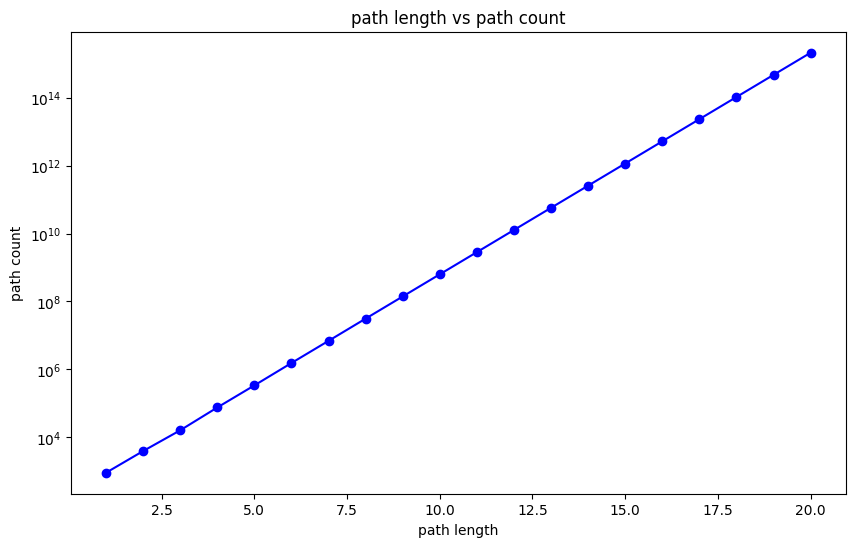

In [27]:
# 画一个折线图
import matplotlib.pyplot as plt


# 改为指数坐标，每个点上显示路径数量
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, max_n + 1), path_cnts, marker='o', linestyle='-', color='b')
plt.title('path length vs path count')
plt.xlabel('path length')
plt.ylabel('path count')

In [ ]:
import networkx as nx
import random

def sample_random_path(graph_data, path_length, start_node=None):
    """
    在图上进行随机游走，以采样一条指定长度的路径。
    此版本使用 MultiDiGraph 来正确处理节点间的平行边。

    Args:
        graph_data (list of tuples): 你的图数据，格式为 (source_id, action, intent, target_id)。
        path_length (int): 期望的路径长度 n (即边的数量)。
        start_node (any, optional): 路径的起始节点。如果为None，则从图中随机选择一个起点。

    Returns:
        list of tuples or None: 包含路径中每一步的元组列表，代表采样的轨迹。
                                如果起点无效或图为空，则返回None。
    """
    if not graph_data:
        print("错误：图数据为空。")
        return None

    # 1. 构建一个有向多重图 (MultiDiGraph)，存储完整的边信息
    G = nx.MultiDiGraph()
    for source, action, intent, target in graph_data:
        G.add_edge(source, target, action=action, intent=intent)

    # 2. 确定起始节点
    if start_node is not None:
        if not G.has_node(start_node):
            raise ValueError(f"错误：指定的起始节点 '{start_node}' 不在图中。")
        current_node = start_node
    else:
        # 从所有节点中随机选择一个
        current_node = random.choice(list(G.nodes()))
    
    # 3. 执行随机游走
    trajectory = []
    print(f"随机游走开始，起点: '{current_node}'，期望长度: {path_length}")

    for i in range(path_length):
        # 获取当前节点的所有出射边 (source, target, key)
        # 这是与DiGraph版本最核心的区别
        outgoing_edges = list(G.out_edges(current_node, keys=True))
        
        # 检查是否遇到“死胡同”
        if not outgoing_edges:
            print(f"警告：在第 {i+1} 步遇到死胡同（节点 '{current_node}' 没有出边）。路径提前终止。")
            break
        
        # 随机选择一条出射边
        source_node, next_node, edge_key = random.choice(outgoing_edges)
        
        # 获取被选中边的属性信息
        # 现在我们使用 u, v, key 来精确获取
        edge_data = G.get_edge_data(source_node, next_node, key=edge_key)
        
        # 记录这一步
        step_tuple = (current_node, edge_data['action'], edge_data['intent'], next_node)
        trajectory.append(step_tuple)
        
        # 更新当前节点
        current_node = next_node
        
    return trajectory

# ==================== 示例用法 ====================
if __name__ == "__main__":
    graph_tuples = triplets
    
    path_n = 5

    random_trajectory = sample_random_path(graph_tuples, path_length=path_n, start_node=None)
    
    if random_trajectory:
        print(f"\n采样到的轨迹 (实际长度 {len(random_trajectory)}):")
        for step in random_trajectory:
            print(f"  {step[0]} -> {step[3]} (动作: {step[1]}, 意图: {step[2]})")

随机游走开始，起点: '('812_24.json', 0, 1, 'http://reddit.com/f/news')'，期望长度: 5

采样到的轨迹 (实际长度 5):
  ('812_24.json', 0, 1, 'http://reddit.com/f/news') -> ('812_24.json', 1, 1, 'http://reddit.com/f/news') (动作: click [1917] where [1917] is button 'Sort by: Hot' hasPopup: menu expanded: False, 意图: The user wants to change the sorting order of the news articles to view them in a different way, such as by newest or most commented.)
  ('812_24.json', 1, 1, 'http://reddit.com/f/news') -> ('812_24.json', 2, 1, 'http://reddit.com/f/news/new') (动作: click [3732] where [3732] is link 'New', 意图: The user aims to view the most recent news articles by changing the sorting order to 'New'.)
  ('812_24.json', 2, 1, 'http://reddit.com/f/news/new') -> ('812_24.json', 3, 1, 'http://reddit.com/f/news/new') (动作: click [4021] where [4021] is button 'Upvote', 意图: The user intends to express approval or support for the first article by upvoting it.)
  ('812_24.json', 3, 1, 'http://reddit.com/f/news/new') -> ('812_24.json